Frontier Investment Management라는 회사가 Harvard, Yale, 그리고 많은 Endowment Fund를 조사한 후 Endowment Index라고 제시한 지수 구성은 미국 주식 11%, 미국 외 선진국 주식 9%, 사모펀드 20%, 신흥국 주식 8%, 전세계 채권 9%, 부동산 10%, 원자재 7%, 헤지펀드 22%, 현금 4%입니다. 논문의 테스트에서는 지수 데이터로 했지만, 실제 ETF로 구현해서 따라할 수 있는지 체크해보기 위하여 ETF로 만들어 보겠습니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


사용한 ETF는 다음과 같습니다. 전세계 채권 ETF인 BNDW를 사용하고 싶었으나 BNDW가 2018년에 출시되어 BNDW 내 미국과 미국 외 비중과 비슷하게 45:55로 BND와 BNDX 비중을 맞추어 대체합니다. 데이터가 온전하게 구해지는 2013년 6월 4일부터 시작합니다.

미국 주식: VTI (Vanguard Total Stock Market ETF)
미국 외 선진국 주식: VEA (Vanguard FTSE Developed Markets ETF)
사모펀드: PSP (Invesco Global Listed Private Equity ETF)
신흥국 주식: VWO (Vanguard FTSE Emerging Markets ETF)
미국 채권: BND (Vanguard Total Bond Market ETF)
미국 외 채권: BNDX (Vanguard Total International Bond ETF)
미국 부동산: VNQ (Vanguard Real Estate ETF)
원자재: GSG (iShares GSCI Commodity Indexed Trust)
헤지펀드: HDG (Proshares Hedge Replication ETF)
현금: SHY (iShares 1-3 Year Treasury Bond ETF)

In [5]:
start = '2013-06-04'
end = '2021-04-30'

vti = web.DataReader('VTI', 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
vea = web.DataReader('VEA', 'yahoo', start, end)['Adj Close'].to_frame("vea_Close")
psp = web.DataReader('PSP', 'yahoo', start, end)['Adj Close'].to_frame("psp_Close")
vwo = web.DataReader('VWO', 'yahoo', start, end)['Adj Close'].to_frame("vwo_Close")
bnd = web.DataReader('BND', 'yahoo', start, end)['Adj Close'].to_frame("bnd_Close")
bndx = web.DataReader('BNDX', 'yahoo', start, end)['Adj Close'].to_frame("bndx_Close")
vnq = web.DataReader('VNQ', 'yahoo', start, end)['Adj Close'].to_frame("vnq_Close")
gsg = web.DataReader('GSG', 'yahoo', start, end)['Adj Close'].to_frame("gsg_Close")
hdg = web.DataReader('HDG', 'yahoo', start, end)['Adj Close'].to_frame("hdg_Close")
shy = web.DataReader('SHY', 'yahoo', start, end)['Adj Close'].to_frame("shy_Close")

In [6]:
bndx.head()

,bndx_Close
Date,
2013-06-04,42.916222
2013-06-05,42.967396
2013-06-06,42.907681
2013-06-07,42.822338
2013-06-10,42.515194


일단 모델 포트폴리오로, 매일 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [7]:
vti_return = vti.pct_change(periods=1)
vea_return = vea.pct_change(periods=1)
psp_return = psp.pct_change(periods=1)
vwo_return = vwo.pct_change(periods=1)
bnd_return = bnd.pct_change(periods=1)
bndx_return = bndx.pct_change(periods=1)
vnq_return = vnq.pct_change(periods=1)
gsg_return = gsg.pct_change(periods=1)
hdg_return = hdg.pct_change(periods=1)
shy_return = shy.pct_change(periods=1)

df_return = pd.concat([vti_return, vea_return, psp_return, vwo_return, bnd_return, bndx_return, vnq_return, gsg_return, hdg_return, shy_return], axis=1)

df_return.head()

,vti_Close,vea_Close,psp_Close,vwo_Close,bnd_Close,bndx_Close,vnq_Close,gsg_Close,hdg_Close,shy_Close
Date,,,,,,,,,,
2013-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-04,-0.004846,0.002137,-0.004325,-0.011375,-0.000365,NaN,-0.013908,0.006084,-0.003931,0.000000
2013-06-05,-0.014133,-0.022388,-0.016508,-0.020374,-0.000365,0.001192,-0.008264,-0.002228,-0.004193,0.000118
2013-06-06,0.009396,0.005725,0.006184,0.010276,0.001340,-0.001390,0.016090,0.004466,0.000496,-0.000118
2013-06-07,0.012412,0.011656,0.005268,-0.004359,-0.002555,-0.001989,0.000141,0.006986,0.002723,-0.000119


In [9]:
df_return['Endowment_return'] = df_return['vti_Close']*0.11+df_return['vea_Close']*0.09+df_return['psp_Close']*0.2+df_return['vwo_Close']*0.08+df_return['bnd_Close']*0.09*0.45+df_return['bndx_Close']*0.09*0.55+df_return['vnq_Close']*0.1+df_return['gsg_Close']*0.07+df_return['hdg_Close']*0.22+df_return['shy_Close']*0.04
df_return.head()

,vti_Close,vea_Close,psp_Close,vwo_Close,bnd_Close,bndx_Close,vnq_Close,gsg_Close,hdg_Close,shy_Close,Endowment_return
Date,,,,,,,,,,,
2013-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-04,-0.004846,0.002137,-0.004325,-0.011375,-0.000365,NaN,-0.013908,0.006084,-0.003931,0.000000,NaN
2013-06-05,-0.014133,-0.022388,-0.016508,-0.020374,-0.000365,0.001192,-0.008264,-0.002228,-0.004193,0.000118,-0.010357
2013-06-06,0.009396,0.005725,0.006184,0.010276,0.001340,-0.001390,0.016090,0.004466,0.000496,-0.000118,0.005619
2013-06-07,0.012412,0.011656,0.005268,-0.004359,-0.002555,-0.001989,0.000141,0.006986,0.002723,-0.000119,0.004015


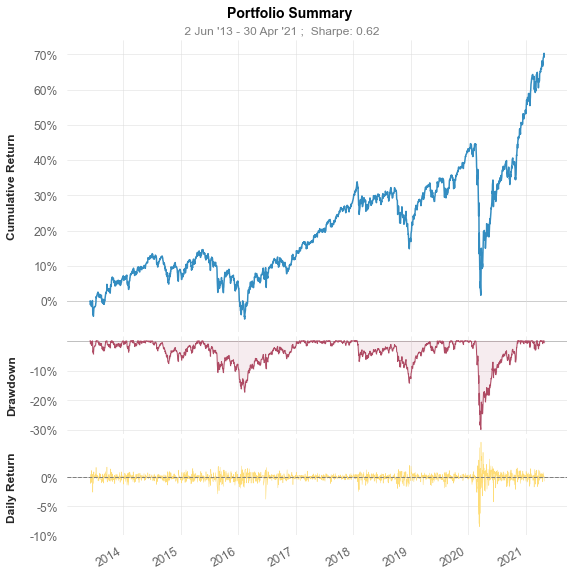

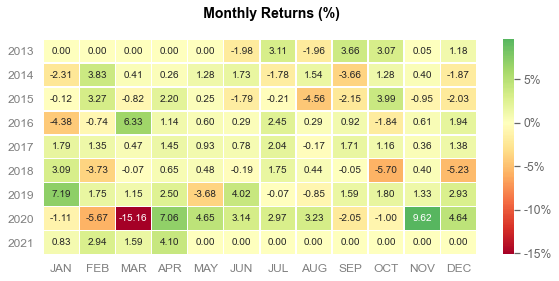

In [10]:
quantstats.reports.plots(df_return['Endowment_return'], mode='basic')

매일 리밸런싱을 한 결과 연 복리 수익률 6.88%, 샤프 비율 0.62, MDD -30% 정도입니다. 연 변동성은 11.83%로, 아래쪽에 제시된 미국 주식 시장 결과 (연 복리 수익률 14.81%, 샤프 비율 0.89, MDD -35%, 연 변동성 17.29%) 및 60/40 전략 결과와 (연 복리 수익률 10.43%, 샤프 비율 0.99, MDD -22.7%, 연 변동성 10.58%) 비교할 때 구성 자산군이 많아 다각화가 많이 된 것 같아 보이지만 성과는 못합니다. ETF로 구현해서 Endowment Fund의 전략을 따라할 수 있는가를 체크하기 위한 목적이었는데, Frontier Investment Management에서 제시한 논문과 테스트 기간에 차이가 있어서 결과가 꽤 다르다고 생각합니다. 실력 좋은 Endowment Fund들은 사모펀드와 헤지펀드 비중을 이렇게 지수로 만든 ETF를 사용하는 것이 아니라 자신들이 찾아낸 실력 좋은 사모펀드와 헤지펀드로 구성할 것이기 때문에 실제 성과는 이보다 높을 것으로 생각합니다.

In [11]:
quantstats.reports.metrics(df_return['Endowment_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2013-06-03
End Period                 2021-04-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          69.23%
CAGR%                      6.88%
Sharpe                     0.62
Sortino                    0.83
Max Drawdown               -29.74%
Longest DD Days            613
Volatility (ann.)          11.83%
Calmar                     0.23
Skew                       -1.74
Kurtosis                   25.51

Expected Daily %           0.03%
Expected Monthly %         0.56%
Expected Yearly %          6.02%
Kelly Criterion            6.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.2%
Expected Shortfall (cVaR)  -1.2%

Payoff Ratio               0.92
Profit Factor              1.13
Common Sense Ratio         1.09
CPC Index                  0.57
Tail Ratio                 0.97
Outlier Win Ratio          3.83
Outlier Loss Ratio         3.8

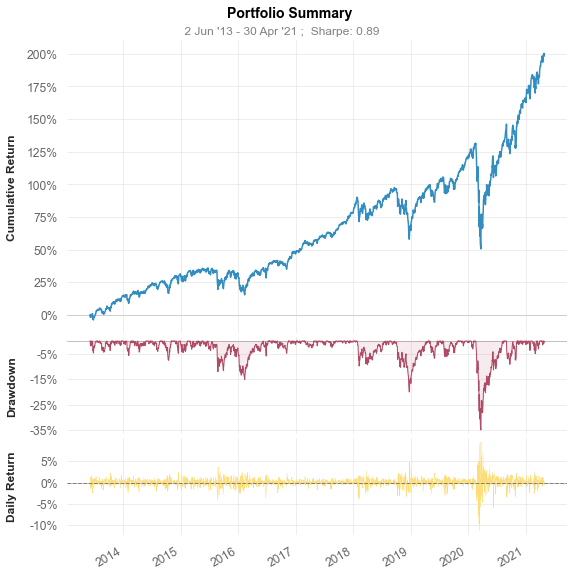

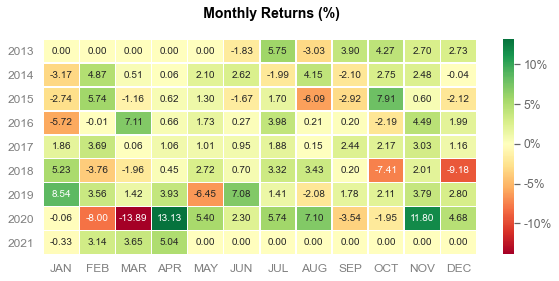

In [12]:
quantstats.reports.plots(df_return['vti_Close'], mode='basic')

In [13]:
quantstats.reports.metrics(df_return['vti_Close'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2013-06-03
End Period                 2021-04-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          198.17%
CAGR%                      14.81%
Sharpe                     0.89
Sortino                    1.23
Max Drawdown               -35.0%
Longest DD Days            350
Volatility (ann.)          17.29%
Calmar                     0.42
Skew                       -0.73
Kurtosis                   19.16

Expected Daily %           0.05%
Expected Monthly %         1.16%
Expected Yearly %          12.91%
Kelly Criterion            9.12%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.73%
Expected Shortfall (cVaR)  -1.73%

Payoff Ratio               0.94
Profit Factor              1.19
Common Sense Ratio         1.11
CPC Index                  0.63
Tail Ratio                 0.93
Outlier Win Ratio          3.8
Outlier Loss Ratio         

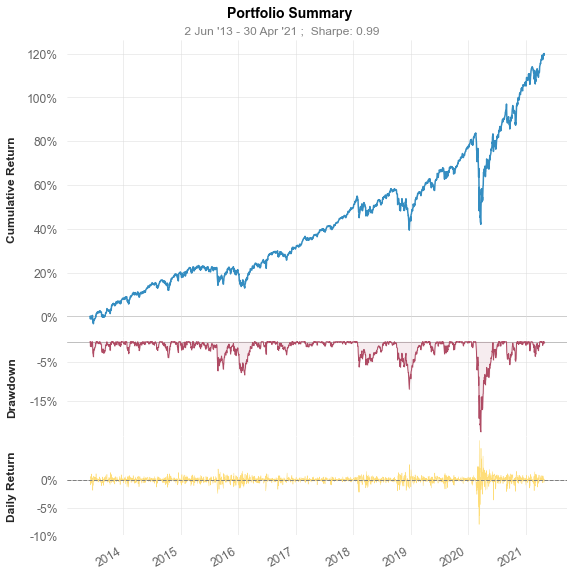

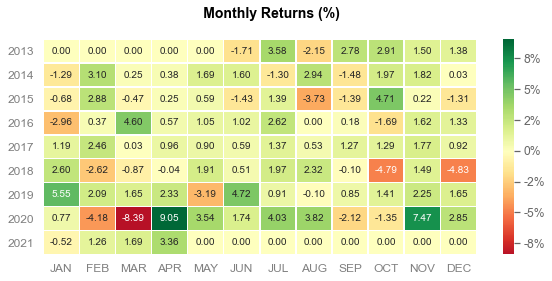

In [14]:
quantstats.reports.plots(df_return['vti_Close']*0.6+df_return['bnd_Close']*0.4, mode='basic')

In [16]:
quantstats.reports.metrics(df_return['vti_Close']*0.6+df_return['bnd_Close']*0.4, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2013-06-03
End Period                 2021-04-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          119.16%
CAGR%                      10.43%
Sharpe                     0.99
Sortino                    1.37
Max Drawdown               -22.7%
Longest DD Days            352
Volatility (ann.)          10.58%
Calmar                     0.46
Skew                       -0.89
Kurtosis                   29.01

Expected Daily %           0.04%
Expected Monthly %         0.83%
Expected Yearly %          9.11%
Kelly Criterion            10.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.05%
Expected Shortfall (cVaR)  -1.05%

Payoff Ratio               0.94
Profit Factor              1.23
Common Sense Ratio         1.19
CPC Index                  0.65
Tail Ratio                 0.97
Outlier Win Ratio          3.91
Outlier Loss Ratio        